In [369]:
import pandas as pd
import numpy as np
import pvlib
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

In [665]:
#Read in weather file and specify column names
weather_file = 'NREL New Iberia.xlsx'
weather = pd.read_excel(weather_file, usecols='A,B,C,D,E,F,G,H', header=None, skiprows=3, nrows=8760)
weather.columns = ['MM/DD/YYYY', 'hh:mm:ss', 'GHI', 'DNI', 'DHI', 'Temp', 'WS', 'RH']
weather.index = weather['MM/DD/YYYY'].astype(str) + ' ' + weather['hh:mm:ss'].astype(str)
weather.index = pd.DatetimeIndex(weather.index)
weather.index = weather.index.tz_localize('Etc/GMT+6', ambiguous='infer')

In [666]:
#Cell Full of User Entered Specs

#desired nameplate production (MW or kW)
nameplate = 60

#assumed install cost ($/Wdc)
cost_install = 0.94
#eligible federal tax credit (% of install cost)
fed_tax_credit = 0.26       #()
#assumed interest rate (apr)
interest = 0.05
#life of project (years)
project_life = 25 
#annual maintenance costs ($/kW) 
cost_maint = 16     #(LLNL)
#assumed years to inverter replacement (years)
inv_replace_years = 10 
#assumed inverter cost ($/W)
cost_inv = 0.14     #(NREL)
#salvage value ($/MW)
sv = 4000   #(NREL)
#variable operating costs ($/kW)
voc = 0.01
#value of electricity ($/kWh)
cost_electricity = 0.075
#term of loan (years)
loan_term = 20
#interest rate (%)
interest = 0.05
#amount financed ($)
loan_amount = 45000000 
#annual payments ($)
loan_payments_ann = 3610920
#losses - used pvwatts
loss_soil = 0.2
loss_spectral = 0.2
loss_lid = 0.15
loss_wiring = 0.2

In [667]:
#get module from database
module = pvlib.pvsystem.retrieve_sam('CECMod')['First_Solar__Inc__FS_6435A']
#get inverter from database
inverter = pvlib.pvsystem.retrieve_sam('CECInverter')['SMA_America__SC720CP_US__with_ABB_EcoDry_Ultra_transformer_']

In [668]:
#calculate optimal string length
#step 1 : calculate max voc
voc_max = module['V_oc_ref'] * (1 + (-6 - 25) * module['beta_oc']/100)
#step 2 : calculate max modules in series
max_strlen = int((1045)/voc_max)
#step 3 : calculate min vmp
vmp_min = module['V_mp_ref'] *(1+( (25 + 36.2 - 25) * (-0.28/100)))
#step 4 : calculate min modules in series
min_strlen = int((inverter['Mppt_low']* 1.1) / vmp_min)
#calculate strings per inverter
#step 5 : calculate max string current
max_str_i = module['I_sc_ref'] * 1.25
#step 6 : calculate max string power
max_str_p = module['STC']*max_strlen
#step 7 : calculate max system voltage
max_sys_v = module['V_mp_ref'] * max_strlen
#step 8: calculate max parallel strings
max_str_par = int(inverter['Pdco'] / max_str_p)
#calculate number of inverters needed to reach nameplate
no_inv =int( nameplate*1000*1000 / inverter['Pdco'] )

In [669]:
#dc system size (MW)
dc_sys = max_str_par*max_strlen*module['STC']*no_inv/1000/1000
#ac system size (MW)
ac_sys = no_inv * inverter['Paco']/1000/1000
#dc/ac ratio
dc_ac_ratio = dc_sys/ac_sys

In [670]:
#racking type - fixed
tilt = 20
lat = 30
lng = 91
alt = 6
sys_azi = 180
#gcr / dist between rows (m)
row_space = 11.5

In [671]:
#running model

#calculates the solar data (zenith,azimuth,eot,elevation,etc)
sol_data = pvlib.solarposition.get_solarposition(time=weather.index,latitude=lat,longitude=lng,altitude=alt,temperature=weather['Temp'])
sol_data['dni_extra']=pvlib.irradiance.get_extra_radiation(weather.index)


#calculate environmental data (poa components, aoi, airmass)
env_data = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt, surface_azimuth=sys_azi, solar_zenith=sol_data['apparent_zenith'],
                                                 solar_azimuth=sol_data['azimuth'], dni=weather['DNI'],ghi=weather['GHI'],
                                                 dhi=weather['DHI'], dni_extra=sol_data['dni_extra'], model='haydavies')
env_data['aoi'] = pvlib.irradiance.aoi(surface_tilt=tilt, surface_azimuth=sys_azi, solar_zenith=sol_data['apparent_zenith'],
                                       solar_azimuth=sol_data['azimuth'])
env_data['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=sol_data['apparent_zenith'])
weather['Pressure'] = pvlib.atmosphere.alt2pres(alt)
env_data['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=env_data['airmass'], pressure=(weather['Pressure']*100))

#predict the cell temperature
tmp=(TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass'])
weather['cell_temp'] = pvlib.temperature.sapm_cell(poa_global=env_data['poa_global'], temp_air=weather['Temp'],
                                                   wind_speed=weather['WS'], a=tmp['a'], b=tmp['b'], deltaT=tmp['deltaT'])


cec_sdm = pvlib.pvsystem.calcparams_cec(env_data['poa_global'], weather['cell_temp'], module['alpha_sc'], module['a_ref'], module['I_L_ref'],
                                       module['I_o_ref'], module['R_sh_ref'], module['R_s'], module['Adjust'])
sdm_output = pvlib.pvsystem.singlediode(cec_sdm[0], cec_sdm[1], cec_sdm[2], cec_sdm[3], cec_sdm[4])

#inverter performance dc (W)
single_inv_performance_dc = (sdm_output['p_mp']*max_strlen*max_str_par)
#system performance dc (MW)
total_system_dc = (single_inv_performance_dc * no_inv)/1000/1000
#inverter performance ac (W)
single_inv_performance_ac = pvlib.inverter.pvwatts(single_inv_performance_dc, pdc0 = inverter['Pdco'])
#system production ac (MW)
total_system_ac = (no_inv * single_inv_performance_ac)/1000/1000

In [672]:
#performance information

#annual energy production (MWh)
ann_dc_energy = total_system_dc.sum()
ann_ac_energy = total_system_ac.sum()
#energy yield
e_yield = (ann_dc_energy / nameplate)
#final yield
f_yield = ann_ac_energy / nameplate
#reference yield
ref_yield = env_data['poa_global'].sum()/1000 / 1
#performance ratio
pr = f_yield/ref_yield
#capacity factor (%)
cuf = (ann_ac_energy/(ac_sys*8760))*100
#system efficiency
n = ann_ac_energy / (env_data['poa_global'].sum()/1000/1000 * (max_str_par*max_strlen*no_inv*(2.475)) )

In [673]:
print(cuf)
print(pr)

5.790530939359452
0.8964631876530197


Text(0.5, 0, 'Month')

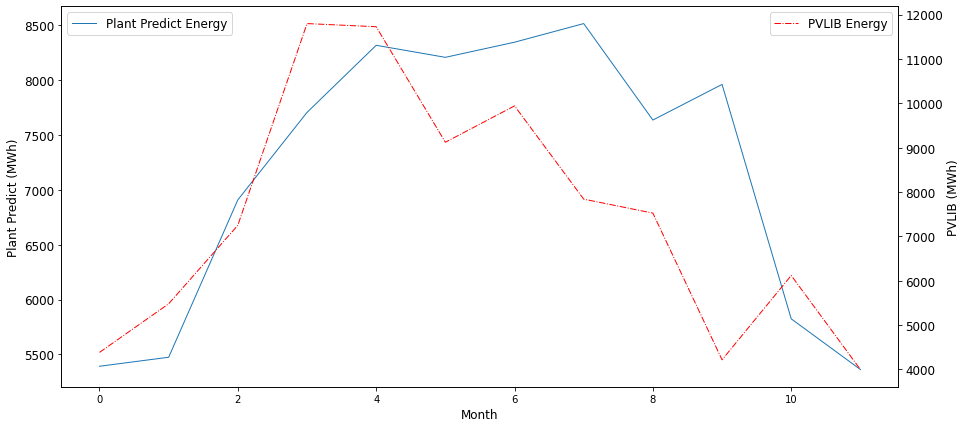

In [674]:
results = pd.read_excel('PP_results.xlsx')
ax = results['Plant Predict'].plot()
ax.set_ylabel('Plant Predict (MWh)')
ax.legend(labels=['Plant Predict Energy'], loc='upper left')
ax2 = ax.twinx()
ax2.plot(results['PVLIB'], c='r', linestyle='-.')
ax2.set_ylabel('PVLIB (MWh)')
ax2.legend(labels=['PVLIB Energy'], loc='upper right')
ax.set_xlabel('Month')

In [675]:
#financial information

#estimated installed costs (before credits and rebates)
cost = cost_install * (nameplate*1000*1000)
#total capital cost
tcc =  cost*(1-fed_tax_credit)
#fixed charge rate, assume fcr=cfr
fcr = (interest/(1-(1+interest)**(-1*project_life)))
#net annual savings

#simple payback period
spp = (cost/(ann_dc_energy*1000*cost_electricity))
#lcoe
lcoe = (((tcc)* (fcr)) + (45))/(ann_dc_energy*1000) + voc
#npv
(cost - (net_sav/(1+interest)**(-project_life)))
print('LCOE = ' + str(lcoe))
print('NPV = ' + str(npv))

LCOE = 0.103929388841339
NPV = 4821286.515156109


## Second System

In [609]:
#Read in weather file and specify column names
weather_file_sam = 'new_iberia_la_30.0026_-91.817_psm3-tmy_60_tmy.csv'
weather_sam = pd.read_csv(weather_file_sam)
weather_sam.index = weather.index

In [610]:
#Cell Full of User Entered Specs

#desired nameplate production (MW or kW)
nameplate = 60

#assumed install cost ($/Wdc)
cost_install = 0.94
#eligible federal tax credit (% of install cost)
fed_tax_credit = 0.26       #(26 USC § 48)
#assumed interest rate (apr)
interest = 0.05
#life of project (years)
project_life = 25 
#annual maintenance costs ($/kW) 
cost_maint = 16     #(LLNL)
#assumed years to inverter replacement (years)
inv_replace_years = 10 
#assumed inverter cost ($/W)
cost_inv = 0.14     #(NREL)
#salvage value ($/MW)
sv = 40000   #(NREL)
#variable operating costs ($/kW)
voc = 0.01
#value of electricity ($/kWh)
cost_electricity = 0.075
#term of loan (years)
loan_term = 20
#interest rate (%)
interest = 0.05
#amount financed ($)
loan_amount = 4500000
#annual payments ($)
loan_payments_ann = 361092
#losses - used pvwatts
loss_soil = 0.2
loss_spectral = 0.2
loss_lid = 0.15
loss_wiring = 0.2

In [611]:
#get module from database
module = pvlib.pvsystem.retrieve_sam('CECMod')['SunPower_SPR_435NE_WHT_D']
#get inverter from database
inverter = pvlib.pvsystem.retrieve_sam('CECInverter')['INGETEAM_POWER_TECHNOLOGY_S_A___Ingecon_Sun_610TL_U_B220_Indoor__220V_']

In [612]:
#calculate optimal string length
#step 1 : calculate max voc
voc_max = module['V_oc_ref'] * (1 + (-6 - 25) * module['beta_oc']/100)
#step 2 : calculate max modules in series
max_strlen = int((1045)/voc_max)
#step 3 : calculate min vmp
vmp_min = module['V_mp_ref'] *(1+( (25 + 36.2 - 25) * (-0.28/100)))
#step 4 : calculate min modules in series
min_strlen = int((inverter['Mppt_low']* 1.1) / vmp_min)
#calculate strings per inverter
#step 5 : calculate max string current
max_str_i = module['I_sc_ref'] * 1.25
#step 6 : calculate max string power
max_str_p = module['STC']*max_strlen
#step 7 : calculate max system voltage
max_sys_v = module['V_mp_ref'] * max_strlen
#step 8: calculate max parallel strings
max_str_par = int(inverter['Pdco'] / max_str_p)
#calculate number of inverters needed to reach nameplate
no_inv =int( nameplate*1000*1000 / inverter['Pdco'] )

In [613]:
##### dc system size (MW)
dc_sys = max_str_par*max_strlen*module['STC']*no_inv/1000/1000
#ac system size (MW)
ac_sys = no_inv * inverter['Paco']/1000/1000
#dc/ac ratio
dc_ac_ratio = dc_sys/ac_sys

In [614]:
#racking type - fixed
tilt = 20
lat = 30
lng = 91
alt = 6
sys_azi = 180
#gcr / dist between rows (m)
row_space = 11.5

In [615]:
#running model

#calculates the solar data (zenith,azimuth,eot,elevation,etc)
sol_data = pvlib.solarposition.get_solarposition(time=weather.index,latitude=lat,longitude=lng,altitude=alt,temperature=weather['Temp'])
sol_data['dni_extra']=pvlib.irradiance.get_extra_radiation(weather.index)


#calculate environmental data (poa components, aoi, airmass)
env_data = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt, surface_azimuth=sys_azi, solar_zenith=sol_data['apparent_zenith'],
                                                 solar_azimuth=sol_data['azimuth'], dni=weather['DNI'],ghi=weather['GHI'],
                                                 dhi=weather['DHI'], dni_extra=sol_data['dni_extra'], model='haydavies')
env_data['aoi'] = pvlib.irradiance.aoi(surface_tilt=tilt, surface_azimuth=sys_azi, solar_zenith=sol_data['apparent_zenith'],
                                       solar_azimuth=sol_data['azimuth'])
env_data['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=sol_data['apparent_zenith'])
weather['Pressure'] = pvlib.atmosphere.alt2pres(alt)
env_data['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=env_data['airmass'], pressure=(weather['Pressure']*100))

#predict the cell temperature
tmp=(TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass'])
weather['cell_temp'] = pvlib.temperature.sapm_cell(poa_global=env_data['poa_global'], temp_air=weather['Temp'],
                                                   wind_speed=weather['WS'], a=tmp['a'], b=tmp['b'], deltaT=tmp['deltaT'])


cec_sdm = pvlib.pvsystem.calcparams_cec(env_data['poa_global'], weather['cell_temp'], module['alpha_sc'], module['a_ref'], module['I_L_ref'],
                                       module['I_o_ref'], module['R_sh_ref'], module['R_s'], module['Adjust'])
sdm_output = pvlib.pvsystem.singlediode(cec_sdm[0], cec_sdm[1], cec_sdm[2], cec_sdm[3], cec_sdm[4])

#inverter performance dc (W)
single_inv_performance_dc = (sdm_output['p_mp']*max_strlen*max_str_par)
#system performance dc (W)
total_system_dc = (single_inv_performance_dc * no_inv)/1000/1000
#inverter performance ac (W)
single_inv_performance_ac = pvlib.inverter.pvwatts(single_inv_performance_dc, pdc0 = inverter['Pdco'])
#system production ac (MW)
total_system_ac = (no_inv * single_inv_performance_ac)/1000/1000

In [616]:
#performance information

#annual energy production (MWh)
ann_dc_energy = total_system_dc.sum()
ann_ac_energy = total_system_ac.sum()
#energy yield
e_yield = (ann_dc_energy / nameplate)
#final yield
f_yield = ann_ac_energy / nameplate
#reference yield
ref_yield = env_data['poa_global'].sum()/1000 / 1
#performance ratio
pr = f_yield/ref_yield
#capacity factor (%)
cuf = (ann_ac_energy/(ac_sys*8760))*100
#system efficiency
n = ann_ac_energy / (env_data['poa_global'].sum()/1000/1000 * (max_str_par*max_strlen*no_inv*(2.475)) )

In [617]:
print(pr)
print(cuf)

0.847806834574251
5.469251656331705


In [622]:
results = pd.read_excel('SAM_results.xlsx')

In [619]:
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (15,7)
mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
mpl.rcParams['axes.titlesize']=22

Text(0.5, 0, 'Month')

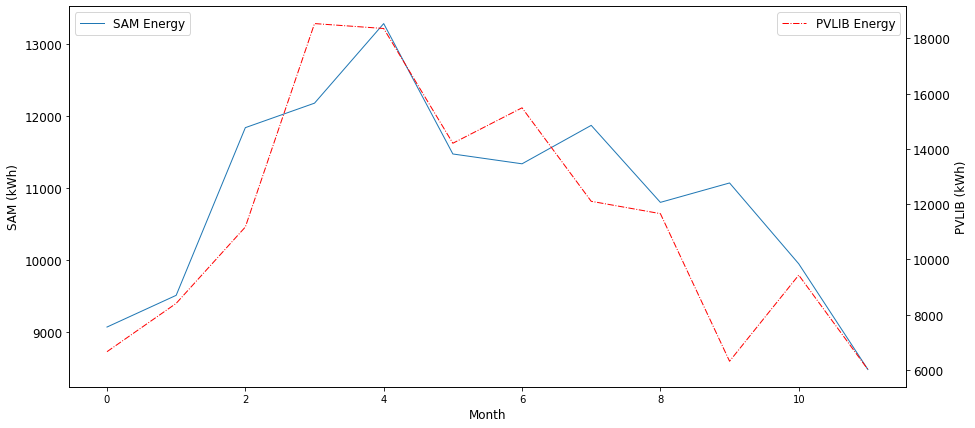

In [624]:
ax = results['SAM'].plot()
ax.set_ylabel('SAM (kWh)')
ax.legend(labels=['SAM Energy'], loc='upper left')
ax2 = ax.twinx()
ax2.plot(results['PVLIB'], c='r', linestyle='-.')
ax2.set_ylabel('PVLIB (kWh)')
ax2.legend(labels=['PVLIB Energy'], loc='upper right')
ax.set_xlabel('Month')

In [663]:
#financial information

#estimated installed costs (before credits and rebates)
cost = cost_install * (nameplate*1000*1000)
#total capital cost
tcc =  cost*(1-fed_tax_credit)
#fixed charge rate, assume fcr=cfr
fcr = (interest/(1-(1+interest)**(-1*project_life)))
#net annual savings
net_sav = loan_amount - cost_electricity*(ann_ac_energy*1000)
#simple payback period
spp = (cost/(ann_dc_energy*1000*cost_electricity))
#lcoe
lcoe = (((tcc)* (fcr)) + (45))/(ann_dc_energy*1000) + voc
#npv
npv = (cost - (net_sav/(1+interest)**(-project_life)))
print('LCOE = ' + str(lcoe))
print('NPV = ' + str(npv))

LCOE = 0.10903873044538367
NPV = 4821286.515156109
